In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
import re
from io import StringIO

%matplotlib inline

# Data Input

### Explanation:
read the content of .data file into the program and store the data as dataframe(variable:data)

In [2]:
#extract data from .data file into DataFrame
title_name = ['Label', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor', 'gill-attachment', 
            'gill-spacing', 'gill-size', 'gill-color', ' stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 
            'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 
            'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
data = np.asanyarray(pd.read_csv(r'mushroom_data/agaricus-lepiota.data', header=None))
data = pd.DataFrame(data, columns=title_name)

### Explantion:
search in the .name file to get all of the attribute of the features by regular expression

In [3]:
#extract types of every features
feature_type = []
with open('mushroom_data/agaricus-lepiota.names') as f:
    lines = f.readlines()
lines = str(lines).split("7. Attribute Information:",1)[1]
lines = str(lines).split("8. Missing Attribute Values:",1)[0]
lines = str(lines).split(':')
pattern = r"/*=([a-z?])"

for line in lines:
    if re.findall(pattern,line):
        feature_type.append(re.findall(pattern,line))

# Data Visualization

### Explanation:
create 3 figures(Overall, poison, edible), each with 22 subplots to visualize the attribute distribution of all features

Also, search every feature to check if every attribute appears in data; if no, append the missing attribute and 0 to the counting array

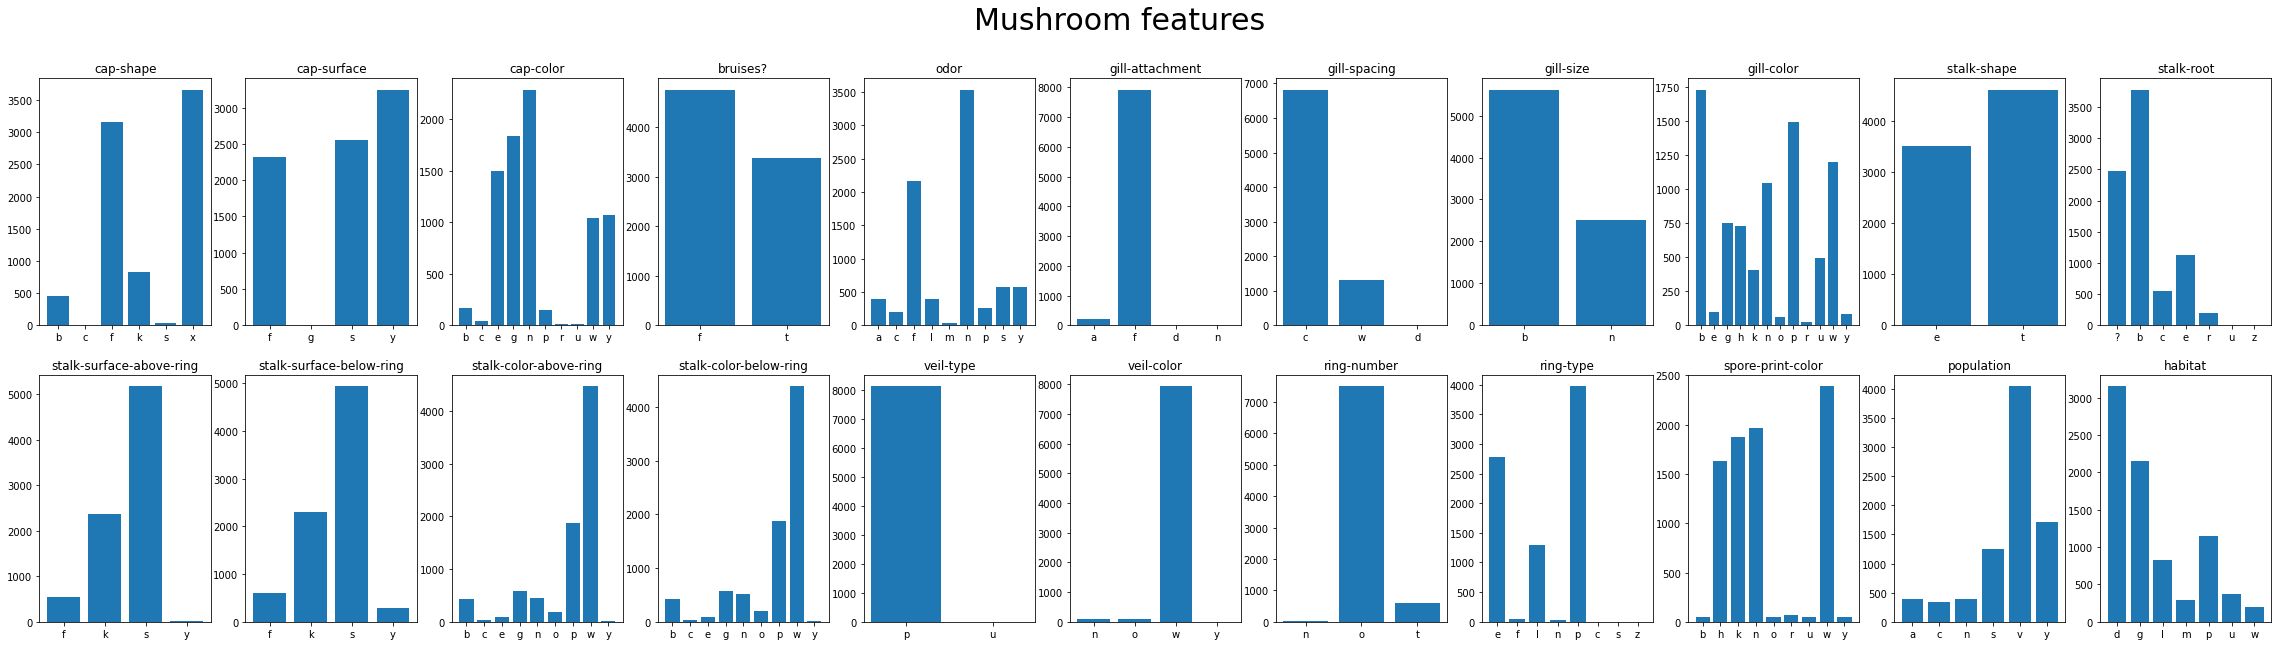

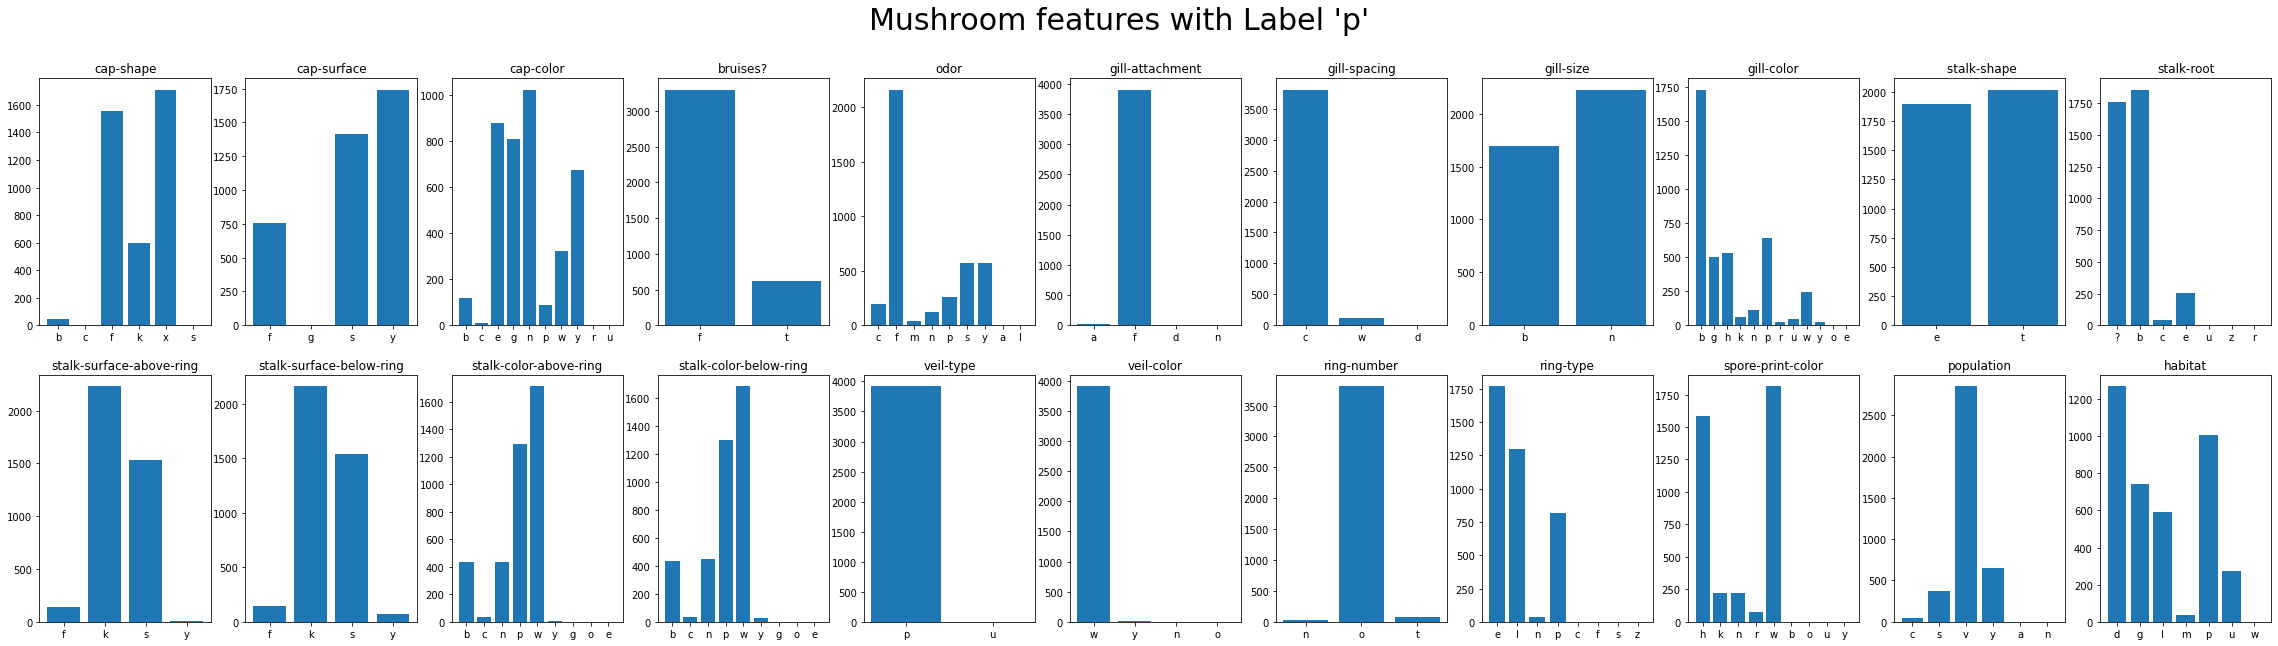

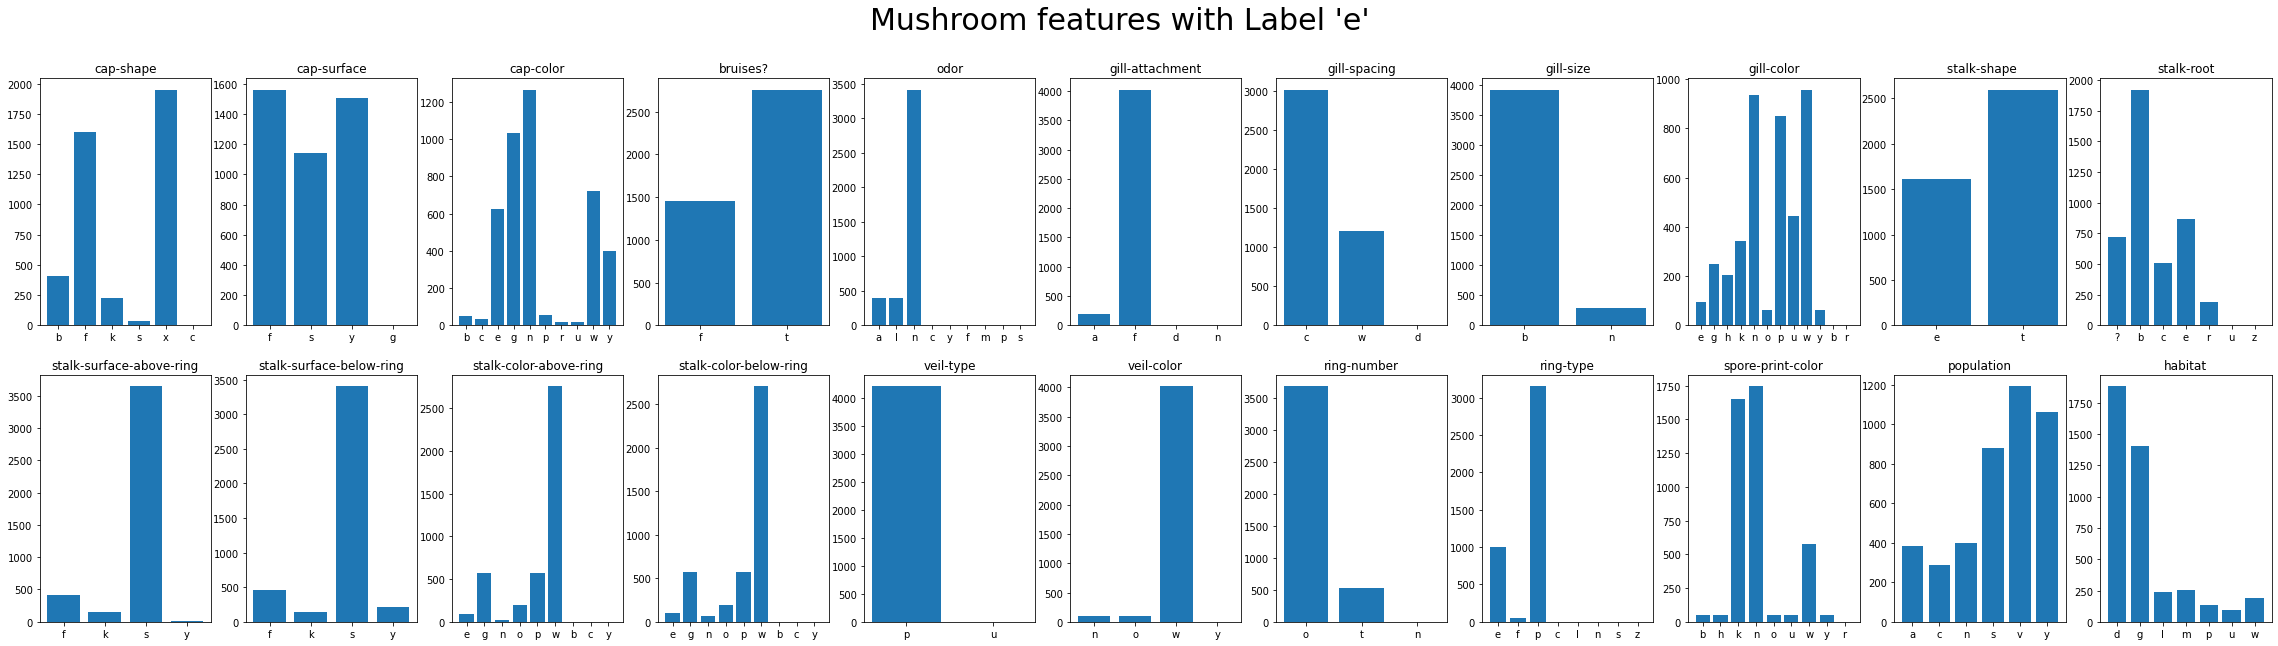

In [4]:
#draw histogram of every feature
fig1 ,axs = plt.subplots(2,11,sharey=False)
fig1.suptitle('Mushroom features',fontsize=30)
fig_p ,axs_p = plt.subplots(2,11,sharey=False)
fig_p.suptitle('Mushroom features with Label \'p\'',fontsize=30)
fig_e ,axs_e = plt.subplots(2,11,sharey=False)
fig_e.suptitle('Mushroom features with Label \'e\'',fontsize=30)
data_p=data[data.Label=='p']
data_e=data[data.Label=='e']
for i in range(22):
    #overall feature
    labels, counts = np.unique(np.asanyarray(data[title_name[i+1]].values), return_counts=True)
    for attribute in feature_type[i+1]:
        if attribute not in labels:
            counts = np.append(counts, 0)
            labels = np.append(labels,attribute)
    axs[int(i/11)][int(i%11)].bar(labels,counts,align='center')
    axs[int(i/11)][int(i%11)].set_title(title_name[i+1])
    
    #feature with 'p'
    labels_p, counts_p = np.unique(np.asanyarray(data_p[title_name[i+1]].values), return_counts=True)
    for attribute in feature_type[i+1]:
        if attribute not in labels_p:
            counts_p = np.append(counts_p, 0)
            labels_p = np.append(labels_p,attribute)
    axs_p[int(i/11)][int(i%11)].bar(labels_p,counts_p,align='center')
    axs_p[int(i/11)][int(i%11)].set_title(title_name[i+1])
    #feature with 'e'
    labels_e, counts_e = np.unique(np.asanyarray(data_e[title_name[i+1]].values), return_counts=True)
    for attribute in feature_type[i+1]:
        if attribute not in labels_e:
            counts_e = np.append(counts_e, 0)
            labels_e = np.append(labels_e,attribute)
    axs_e[int(i/11)][int(i%11)].bar(labels_e,counts_e,align='center')
    axs_e[int(i/11)][int(i%11)].set_title(title_name[i+1])

fig1.set_figheight(10)
fig1.set_figwidth(40)
fig_p.set_figheight(10)
fig_p.set_figwidth(40)
fig_e.set_figheight(10)
fig_e.set_figwidth(40)
plt.show()

# Data Preprocessing

### Explanation:
search for missing attribute in every feature, and delete the whole feature once '?' is found

arrange the number of attribute every feature should have and make them into an array(variable:feature_attribute_num)

In [5]:
#delete feature with missing value
for name in data.columns:
    if name == 'Label':
        continue
    if '?' in data[name].values:
        data = data.drop(columns=name)
        continue
for i in range(len(feature_type)):
    if '?' in feature_type[i]:
        del feature_type[i]
        break
    
feature_attribute_num = []
for l in feature_type:
    feature_attribute_num.append(len(l))

# Model Construction

### Explanation:
seperate the data into feature and Label

encode the feature part to fit the Naive Bayes model afterward

In [6]:
#split data to Labal and feature, then encode feature
from sklearn.naive_bayes import CategoricalNB
from sklearn import preprocessing

Label = pd.DataFrame(data['Label'], columns=['Label'])
feature = data.drop(columns=['Label'])

le = preprocessing.LabelEncoder()
for name in feature.columns:
    feature[name] = le.fit_transform(feature[name])

## Holdout validation 
### Explanation:
split the data into test_feature, train_feature, test_Label, train_Label(train:test=7:3)

Shuffle the data

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Holdout 7:3 and shuffle
test_feature, train_feature, test_Label, train_Label = train_test_split(
    feature,Label,test_size=0.7, shuffle=True)

HAccurancy = []
HPrecision_p = []
HPrecision_e = []
HRecall_p = []
HRecall_e = []

### Explanation:
fit the training data into the Naive Bayes model without Laplace smoothing, and compare the predicted result and the ground truth to get 

Accuracy, Precision, Sensitivity, and Confusion matrix

In [8]:
#without Laplace
clt = CategoricalNB(alpha=1.0e-10,min_categories=feature_attribute_num[1:])
clt.fit(train_feature,train_Label.values.ravel())
Hpredict = clt.predict(test_feature)
clt.score(train_feature, train_Label)

print("Holdout without Laplace smoothing:")
HAccurancy.append(clt.score(test_feature, test_Label))
HPrecision_p.append(precision_score(test_Label.values.flatten(),Hpredict,pos_label='p'))
HPrecision_e.append(precision_score(test_Label.values.flatten(),Hpredict,pos_label='e'))
HRecall_p.append(recall_score(test_Label.values.flatten(),Hpredict,pos_label='p'))
HRecall_e.append(recall_score(test_Label.values.flatten(),Hpredict,pos_label='e'))
print("Confusion_matrix:\n",confusion_matrix(test_Label,Hpredict,labels=['p','e']))

Holdout without Laplace smoothing:
Confusion_matrix:
 [[1175    0]
 [   2 1260]]


### Explanation:
fit the training data into the Naive Bayes model witt Laplace smoothing(alpha = 1, 10, 100), and compare the predicted result and the ground truth to get 

Accuracy, Precision, Sensitivity, and Confusion matrix

In [9]:
#with Laplace
for i in range(3):
    clt = CategoricalNB(alpha=float(pow(10,i)),min_categories=feature_attribute_num[1:])
    clt.fit(train_feature,train_Label.values.ravel())
    Hpredict = clt.predict(test_feature)
    print("\nHoldout with Laplace smoothing(alpha="+str(pow(10,i))+"):")
    HAccurancy.append(clt.score(test_feature, test_Label))
    HPrecision_p.append(precision_score(test_Label.values.flatten(),Hpredict,pos_label='p'))
    HPrecision_e.append(precision_score(test_Label.values.flatten(),Hpredict,pos_label='e'))
    HRecall_p.append(recall_score(test_Label.values.flatten(),Hpredict,pos_label='p'))
    HRecall_e.append(recall_score(test_Label.values.flatten(),Hpredict,pos_label='e'))
    print("Confusion_matrix:\n",confusion_matrix(test_Label,Hpredict,labels=['p','e']))


Holdout with Laplace smoothing(alpha=1):
Confusion_matrix:
 [[1081   94]
 [   3 1259]]

Holdout with Laplace smoothing(alpha=10):
Confusion_matrix:
 [[1032  143]
 [   5 1257]]

Holdout with Laplace smoothing(alpha=100):
Confusion_matrix:
 [[ 998  177]
 [  13 1249]]


### H-holdout validation Data Visualize
compare the Accuracy, Precision, Sensitivity 

of different value of alpha apply in the Naive Bayes model

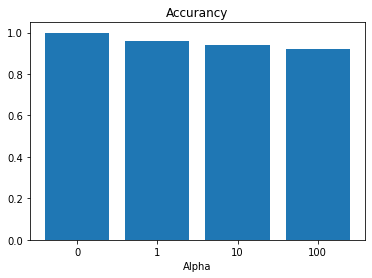

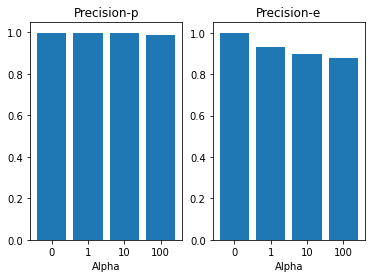

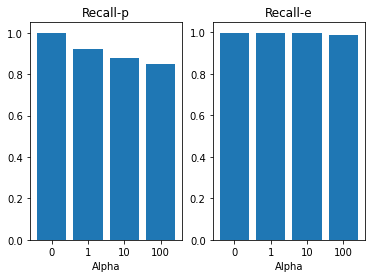

In [10]:
x = np.arange(4)
plt.title("Accurancy")
plt.bar(x, HAccurancy)
plt.xticks(x,['0','1','10','100'])
plt.xlabel("Alpha")
plt.show()

fig ,ax = plt.subplots(1,2,sharex=True)
plt.xticks(ticks=range(0,4),labels=['0','1','10','100'])
ax[0].set_title("Precision-p")
ax[0].bar(x,HPrecision_p)
ax[0].set_xlabel("Alpha")
ax[1].set_title("Precision-e")
ax[1].bar(x,HPrecision_e)
ax[1].set_xlabel("Alpha")
plt.show()

fig_r ,ax_r = plt.subplots(1,2,sharex=True)
plt.xticks(ticks=range(0,4),labels=['0','1','10','100'])
ax_r[0].set_title("Recall-p")
ax_r[0].bar(x,HRecall_p)
ax_r[0].set_xlabel("Alpha")
ax_r[1].set_title("Recall-e")
ax_r[1].bar(x,HRecall_e)
ax_r[1].set_xlabel("Alpha")
plt.show()


## K-fold cross-validation

### Explanation:
Introduce KFold function in the code and split the data into 3 fold

Shuffle the data

In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True)
kf.get_n_splits(feature)

KAccurancy = []
KPrecision_p = []
KPrecision_e = []
KRecall_p = []
KRecall_e = []

### Explanation:
compute the Accuracy, Precision, Sensitivity, and Confusion matrix of each fold without Laplace smoothing, and find the mean of all folds

In [12]:
#without Laplace
NConfusion = np.zeros((2,2))
NAccurancy_sum = 0
NPrecision_sum_p = 0
NPrecision_sum_e = 0
NRecall_sum_p = 0
NRecall_sum_e = 0
for train_index, test_index in kf.split(feature):
    X_train, X_test = feature.values[train_index], feature.values[test_index]
    y_train, y_test = Label.values[train_index], Label.values[test_index]
    clt = CategoricalNB(alpha=1.0e-10,min_categories=feature_attribute_num[1:])
    clt.fit(X_train,y_train.ravel())
    Kpredict = clt.predict(X_test)
    NAccurancy_sum += clt.score(X_test, y_test)
    NPrecision_sum_p += precision_score(y_test.flatten(),Kpredict,pos_label='p')
    NPrecision_sum_e += precision_score(y_test.flatten(),Kpredict,pos_label='e')
    NRecall_sum_p += recall_score(y_test.flatten(),Kpredict,pos_label='p')
    NRecall_sum_e += recall_score(y_test.flatten(),Kpredict,pos_label='e')
    Kpredict = clt.predict(X_test)
    NConfusion += confusion_matrix(y_test,Kpredict,labels=['p','e'])

print("K-fold without Laplace smoothing:")
KAccurancy.append(NAccurancy_sum/3.0)
KPrecision_p.append(NPrecision_sum_p/3.0)
KPrecision_e.append(NPrecision_sum_e/3.0)
KRecall_p.append(NRecall_sum_p/3.0)
KRecall_e.append(NRecall_sum_e/3.0)
print("Confusion_matrix:\n",(NConfusion/3).astype(int))

K-fold without Laplace smoothing:
Confusion_matrix:
 [[1304    1]
 [   9 1393]]


### Explanation:
compute the Accuracy, Precision, Sensitivity, and Confusion matrix of each fold with Laplace smoothing(alpha=1, 10, 100), and find the mean of all folds

In [13]:
#with Laplace
for i in range(3):
    Confusion=np.zeros((2,2))
    Accurancy_sum=0
    Precision_sum_p = 0
    Precision_sum_e = 0
    Recall_sum_p = 0
    Recall_sum_e = 0
    for train_index, test_index in kf.split(feature):
        X_train, X_test = feature.values[train_index], feature.values[test_index]
        y_train, y_test = Label.values[train_index], Label.values[test_index]
        clt = CategoricalNB(alpha=float(pow(10,i)),min_categories=feature_attribute_num[1:])
        clt.fit(X_train,y_train.ravel())
        Kpredict = clt.predict(X_test)
        Accurancy_sum += clt.score(X_test, y_test)
        Precision_sum_p += precision_score(y_test.flatten(),Kpredict,pos_label='p')
        Precision_sum_e += precision_score(y_test.flatten(),Kpredict,pos_label='e')
        Recall_sum_p += recall_score(y_test.flatten(),Kpredict,pos_label='p')
        Recall_sum_e += recall_score(y_test.flatten(),Kpredict,pos_label='e')
        Confusion += confusion_matrix(y_test,Kpredict,labels=['p','e'])

    print("\nK-fold with Laplace smoothing(alpha="+str(pow(10,i))+"):")
    KAccurancy.append(Accurancy_sum/3.0)
    KPrecision_p.append(Precision_sum_p/3.0)
    KPrecision_e.append(Precision_sum_e/3.0)
    KRecall_p.append(Recall_sum_p/3.0)
    KRecall_e.append(Recall_sum_e/3.0)
    print("Confusion_matrix:\n",(Confusion/3).astype(int))


K-fold with Laplace smoothing(alpha=1):
Confusion_matrix:
 [[1200  105]
 [   7 1395]]

K-fold with Laplace smoothing(alpha=10):
Confusion_matrix:
 [[1140  164]
 [  10 1392]]

K-fold with Laplace smoothing(alpha=100):
Confusion_matrix:
 [[1084  221]
 [  19 1383]]


### K-Fold cross validation Data Visualize
compare the Accuracy, Precision, Sensitivity 

of different value of alpha apply in the Naive Bayes model

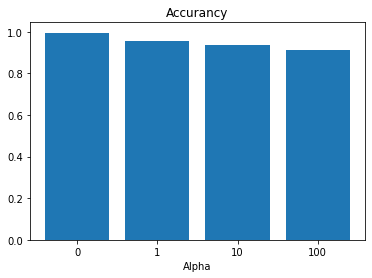

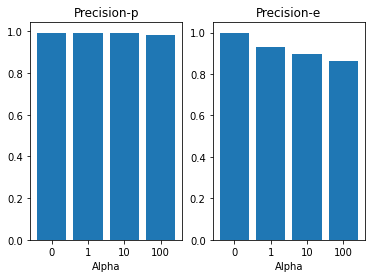

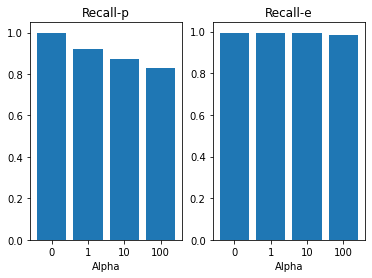

In [14]:
#K-fold cross visualization
x = np.arange(4)
plt.title("Accurancy")
plt.bar(x, KAccurancy)
plt.xticks(x,['0','1','10','100'])
plt.xlabel("Alpha")
plt.show()

fig ,ax = plt.subplots(1,2,sharex=True)
plt.xticks(ticks=range(0,4),labels=['0','1','10','100'])
ax[0].set_title("Precision-p")
ax[0].bar(x,KPrecision_p)
ax[0].set_xlabel("Alpha")
ax[1].set_title("Precision-e")
ax[1].bar(x,KPrecision_e)
ax[1].set_xlabel("Alpha")
plt.show()

fig_r ,ax_r = plt.subplots(1,2,sharex=True)
plt.xticks(ticks=range(0,4),labels=['0','1','10','100'])
ax_r[0].set_title("Recall-p")
ax_r[0].bar(x,KRecall_p)
ax_r[0].set_xlabel("Alpha")
ax_r[1].set_title("Recall-e")
ax_r[1].bar(x,KRecall_e)
ax_r[1].set_xlabel("Alpha")
plt.show()

# Comparison and Conclusion
No matter we use H-holdout of K-fold validation, the accuracy without Laplace smoothing is higher than the accuracy with Laplace smoothing, which is quite the opposite to other prediction. However, I believe it's due to the following reason:

* Missing attribute is missing in the entire data rather than in training data

    As the Laplace smoothing is a certain skill to deal with the attribute that didn't appear in the training data but appears in the testing data by lower a bit of existing attribute to raise the overall accuracy. However, in our case, the attribute didn't appear in both traing data and testing data. Therefore, the action of lower the existing attribute is without any meaning, only to cause the overall accurancy to drop.


## Compare H-holdout & K-fold
The Accuracy, Precision, Sensitivity, and Confusion matrix of the both validation are very similar. Furthermore, the Precision and Recall of both validation can show the symmetry of the two label[p,e], we can observe that Precision-p is very simalar to Recall-e, and Precision-e is very simalar to Recall-p.

However the unstability of H-holdout is bigger than K-fold after several test, as we have no control over the 70% training data, which can be biased. However, K-fold is the average of the three fold, which would be more stable. 

# Question
Show 𝑃(𝑋𝑠𝑡𝑎𝑙𝑘−𝑐𝑜𝑙𝑜𝑟−𝑏𝑒𝑙𝑜𝑤−𝑟𝑖𝑛𝑔|𝑌=𝑒) with and without Laplace smoothing by bar charts

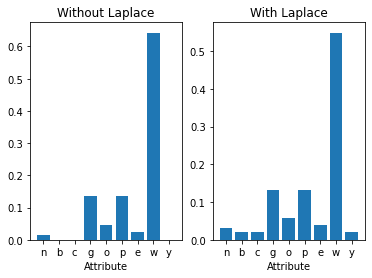

In [15]:
NLaplace = []
Laplace = []
k=100
m=len(feature_type[14])
target = pd.DataFrame(data[['Label','stalk-color-below-ring']], 
        columns=['Label','stalk-color-below-ring'])[data['Label']=='e']
for a in feature_type[14]:
        num = len(target[target['stalk-color-below-ring']==a])
        NLaplace.append(float(num)/len(target))
        Laplace.append(float(num+k)/(len(target)+k*m))

x = np.arange(9)
fig ,ax = plt.subplots(1,2,sharex=True)
plt.xticks(ticks=range(0,9),labels=['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'])
ax[0].set_title("Without Laplace")
ax[0].bar(x,NLaplace)
ax[0].set_xlabel("Attribute")
ax[1].set_title("With Laplace")
ax[1].bar(x,Laplace)
ax[1].set_xlabel("Attribute")
plt.show()

## Anaylze
we can see from the chart that the attributes which doesn't appear in the data is raised to a certain percentage, and the other existing attributes' percentage is lower to keep the total sum of the percentage as 1, which matches what is mentioned "a certain skill to deal with the attribute that didn't appear in the training data but appears in the testing data by lower a bit of existing attribute to raise the overall accuracy"